# Extracting light curves

Performing photometry on the detected variable sources.

**Note:** This notebook requires datafiles that are not provided in this repo to run

In [4]:
import numpy as np
import subprocess

from astropy.io import fits
from astropy.table import Table, Column, join
import astropy.units as u
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.timeseries import BoxLeastSquares, LombScargle
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

from scipy.stats import chisquare
from scipy.signal import medfilt, find_peaks

from ccdproc import CCDData, Combiner, subtract_overscan, trim_image, create_deviation

from photutils import DAOStarFinder, CircularAperture, aperture_photometry

from glob import glob

import matplotlib

%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import NullLocator

#### Reading in the data

In [3]:
# The table of sources

full_crossmatch_table = Table.read("../data/NGC1866_data_tables/variable_star_parameter_table_no_period.ecsv",
                                   format="ascii.ecsv")

In [5]:
sub_img_fles = glob("../data/NGC1866_images/*sub.fits")

In [6]:
sub_img_by_band = dict()

for fle in sub_img_fles:
    band = fits.getheader(fle)['FILTER']
    if not sub_img_by_band.get(band):
        sub_img_by_band[band] = [fle]
    sub_img_by_band[band].append(fle)

In [7]:
v_sub_fles = sub_img_by_band["V"]

In [8]:
# The original I-band files are not correctly aligned
i_sub_fles = glob("../data/NGC1866_images/*sub_new.fits")

In [9]:
len(v_sub_fles)

27

In [10]:
len(i_sub_fles)

24

#### V-band

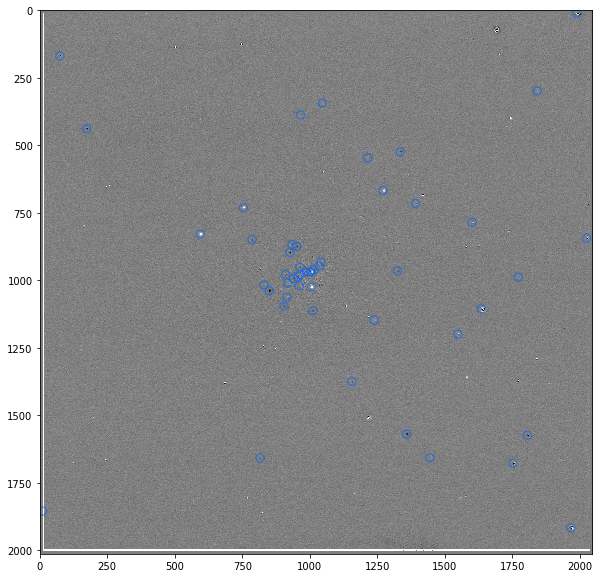

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

img = fits.getdata(v_sub_fles[0])

ax.imshow(img, cmap='gray',vmin=-10,vmax=10)

positions_v = (full_crossmatch_table['x_v'], full_crossmatch_table['y_v'])
apertures_v = CircularAperture(positions_v, r=15.)
apertures_v.plot(color='#0061ff', lw=1.5, alpha=0.5)

In [12]:
positions_v = [(x['x_v'], x['y_v']) for x in full_crossmatch_table]
apertures_v = CircularAperture(positions_v, r=6)

In [13]:
dates = []
mags = {}
for i in full_crossmatch_table["id"]:
    mags[i]= []
errs = {}
for i in full_crossmatch_table["id"]:
    errs[i]= []

for fle in v_sub_fles:
    
    # Getting what we need from the file
    hdu = fits.open(fle)
    img = hdu[0].data
    header = hdu[0].header
    hdu.close()
    
    dates.append(hdu[0].header["MJD-OBS"])
    
    # Getting the uncertainty
    data = CCDData(np.abs(img), unit=u.adu)
    data_with_deviation = create_deviation(data, gain=header['GAIN'] * u.electron/u.adu,
                                                 readnoise=header['RDNOISE'] * u.electron)
    uncertainty = data_with_deviation.uncertainty.array

    phot_table = aperture_photometry(img, apertures_v, error=uncertainty)
    
    for star in phot_table:
        mags[star['id']].append(star['aperture_sum']*header['GAIN']/header['EXPTIME'])
        errs[star['id']].append(star['aperture_sum_err']*header['GAIN']/header['EXPTIME'])

In [14]:
lc_table_v = Table(names=["filename","date_obs"], data=[v_sub_fles,dates])
for i in full_crossmatch_table["id"]:
    lc_table_v.add_column(Column(name=f"mag_{i}",data=mags[i]))
    lc_table_v.add_column(Column(name=f"mag_err_{i}",data=errs[i]))

In [15]:
# A couple of sources are near the edge of the detector and off the edge in some images.

for i in full_crossmatch_table["id"]:
    nans = sum(np.isnan(lc_table_v[f'mag_{i}']))
    if nans > 0:
        print(f'{i}: {nans}')

1: 2
14: 6
49: 15


In [16]:
# Make sure the table is in order by observation time
lc_table_v.sort("date_obs")

#### Saving the V-band light curve table

In [114]:
lc_table_v.write("../data/NGC1866_data_tables/Vband_variable_lightcurve_table.ecsv",format='ascii.ecsv')

#### Plotting all the light curves at once 

(for fun)

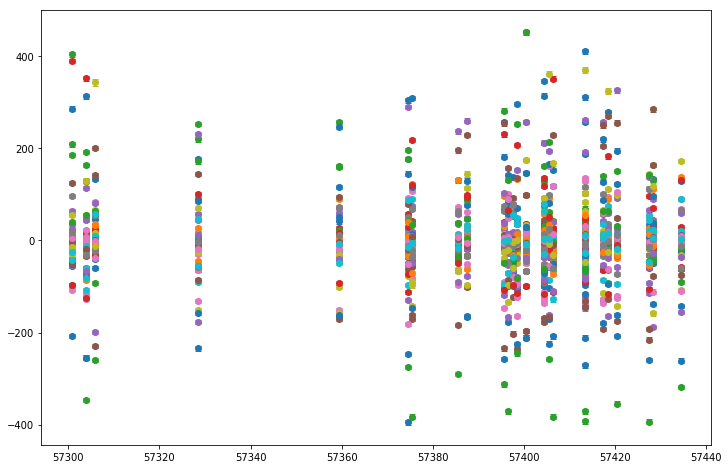

In [17]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

for i in full_crossmatch_table['id']:
    ax.errorbar(lc_table_v['date_obs'],lc_table_v[f'mag_{i}'],yerr=lc_table_v[f'mag_err_{i}'],
                marker='o',linestyle='None',capsize=3)
    

#### I-band

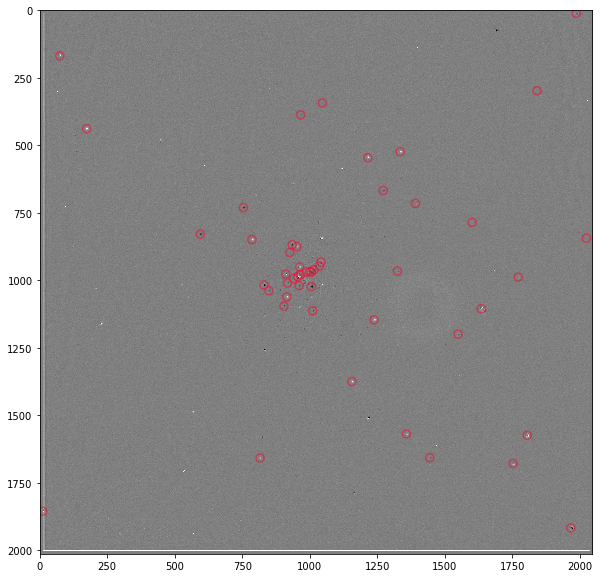

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

img = fits.getdata(i_sub_fles[2])

ax.imshow(img, cmap='gray',vmin=-40,vmax=40)

positions_i = (full_crossmatch_table['x_i'], full_crossmatch_table['y_i'])
apertures_i = CircularAperture(positions_v, r=15.)
apertures_i.plot(color='#ff002b', lw=1.5, alpha=0.5)

In [19]:
positions_i = [(x['x_i'], x['y_i']) for x in full_crossmatch_table]
apertures_i = CircularAperture(positions_i, r=6)

In [20]:
dates = []
mags = {}
for i in full_crossmatch_table["id"]:
    mags[i]= []
errs = {}
for i in full_crossmatch_table["id"]:
    errs[i]= []

for fle in i_sub_fles:
    
    # Getting what we need from the file
    hdu = fits.open(fle)
    img = hdu[0].data
    header = hdu[0].header
    hdu.close()
    
    dates.append(hdu[0].header["MJD-OBS"])
    
    # Getting the uncertainty
    data = CCDData(np.abs(img), unit=u.adu)
    data_with_deviation = create_deviation(data, gain=header['GAIN'] * u.electron/u.adu,
                                                 readnoise=header['RDNOISE'] * u.electron)
    uncertainty = data_with_deviation.uncertainty.array

    phot_table = aperture_photometry(img, apertures_i, error=uncertainty)
    
    for star in phot_table:
        mags[star['id']].append(star['aperture_sum']*header['GAIN']/header['EXPTIME'])
        errs[star['id']].append(star['aperture_sum_err']*header['GAIN']/header['EXPTIME'])

In [21]:
lc_table_i = Table(names=["filename","date_obs"], data=[i_sub_fles,dates])
for i in full_crossmatch_table["id"]:
    lc_table_i.add_column(Column(name=f"mag_{i}",data=mags[i]))
    lc_table_i.add_column(Column(name=f"mag_err_{i}",data=errs[i]))

In [22]:
# A couple of sources are near the edge of the detector and off the edge in some images.

for i in full_crossmatch_table["id"]:
    nans = sum(np.isnan(lc_table_i[f'mag_{i}']))
    if nans > 0:
        print(f'{i}: {nans}')

1: 1
14: 2
49: 11


In [23]:
# Make sure the table is in order by observation time
lc_table_i.sort("date_obs")

#### Saving the I-band light curve table

In [115]:
lc_table_i.write("../data/NGC1866_data_tables/Iband_variable_lightcurve_table.ecsv",format='ascii.ecsv')

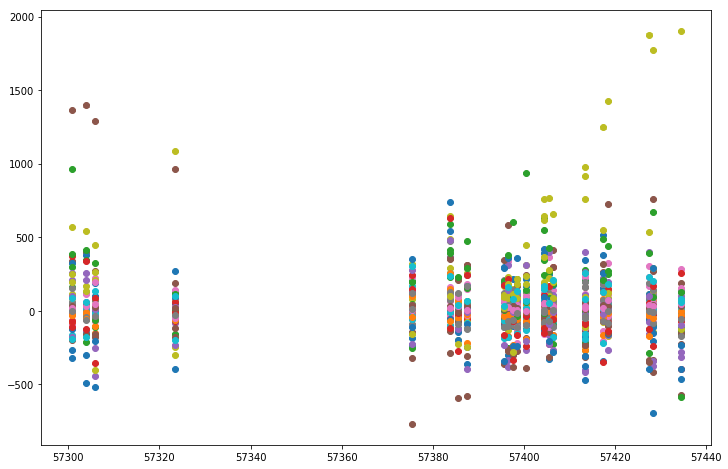

In [24]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

for i in full_crossmatch_table['id']:
    ax.errorbar(lc_table_i['date_obs'],lc_table_i[f'mag_{i}'],yerr=lc_table_i[f'mag_err_{i}'],
                marker='o',linestyle='None',capsize=3)
    